In [114]:
import pandas as pd
import ast
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import matplotlib.pyplot as plt
from nltk.stem.porter import *
import numpy as np
import nltk
np.random.seed(2018)
nltk.download('wordnet')

MORE_STOP_WORDS = frozenset({'birdwatch', 'lives', 'people', 'live', 'give','believe', 'contribute', 'belief', 'https','satire', 'clear', 'real', 'post', 'tweets','posted', 'posting','take','claim','claiming','claimed', 'inform', 'better', 'live','informing', 'informed','like', 'quote', 'note', 'article', 'news', 'html', 'faq', 'quoting', 'quotation', 'need', 'quot', 'quoted', 'quoting', 'claim', 'fact', 'check', 'context', 'factcheck', 'claimed', 'claiming', 'false', 'content', 'actual', 'include', 'including', 'say', 'change', 'know', 'knowing', 'source', 'sourced', 'sourcing', 'opinion', 'misleading', 'cause', 'question', 'media', 'give', 'require', 'sourc', 'question', 'effect', 'tweet', 'photo', 'evidence', 'image', 'twitter', 'status', 'account', 'effects', 'say', 'says','factual', 'true', 'author', 'user', 'tweeted', 'faq ', 'wikipedia', 'wiki', 'video', 'say', 'report', 'posting', 'post', 'origin', 'report', 'cause', 'causing', 'claim', 'post', 'link', 'fake', 'statement', 'data', 'group', 'state', 'social', 'inform'})

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/NiharikaBhaskar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [115]:
df = pd.read_csv("all_tweets_with_text.csv")



In [116]:
df.head(5)

,data,cn_noteId,cn_noteAuthorParticipantId,cn_createdAtMillis,cn_tweetId,cn_classification,cn_believable,cn_harmful,cn_validationDifficulty,cn_misleadingOther,...,cn_misleadingSatire,cn_notMisleadingOther,cn_notMisleadingFactuallyCorrect,cn_notMisleadingOutdatedButNotWhenWritten,cn_notMisleadingClearlySatire,cn_notMisleadingPersonalOpinion,cn_trustworthySources,cn_summary,errors,tweet_text
0,"{'id': '1377030478167937024', 'lang': 'en', 'c...",1537142913737428992,E786F29F77E52D959A2604701A9A4F491B0BA83687E515...,1655318404027,1377030478167937024,MISINFORMED_OR_POTENTIALLY_MISLEADING,BELIEVABLE_BY_MANY,CONSIDERABLE_HARM,EASY,0,...,0,0,0,0,0,0,1,Forbes has a good rundown of the investigation...,NaN,...and my father has even been wearing a wire ...
1,"{'conversation_id': '1536848327979016193', 'cr...",1537145358521839617,E786F29F77E52D959A2604701A9A4F491B0BA83687E515...,1655318986910,1536848327979016193,NOT_MISLEADING,NaN,NaN,NaN,0,...,0,0,0,0,1,1,0,They are expressing a personal opinion in a st...,NaN,people who choose to communicate and fix thing...
2,"{'public_metrics': {'retweet_count': 3427, 're...",1537147343715282945,E786F29F77E52D959A2604701A9A4F491B0BA83687E515...,1655319460217,1537080831751102467,MISINFORMED_OR_POTENTIALLY_MISLEADING,BELIEVABLE_BY_MANY,LITTLE_HARM,EASY,0,...,0,0,0,0,0,0,1,Teslas purchased after 12/31/19 are not eligib...,NaN,@teslaownersSV Buyers of competing electric ca...
3,{'edit_history_tweet_ids': ['15371961689539747...,1537204430730211328,E786F29F77E52D959A2604701A9A4F491B0BA83687E515...,1655333070821,1537196168953974784,MISINFORMED_OR_POTENTIALLY_MISLEADING,BELIEVABLE_BY_MANY,CONSIDERABLE_HARM,EASY,0,...,0,0,0,0,0,0,1,The Jan 6th riots were encouraged by the sitti...,NaN,@shaneyyricch @ElijahSchaffer https://t.co/iAD...
4,"{'created_at': '2022-06-23T21:40:39.000Z', 'ed...",1540422295029551104,E786F29F77E52D959A2604701A9A4F491B0BA83687E515...,1656100269455,1540087463099736065,MISINFORMED_OR_POTENTIALLY_MISLEADING,BELIEVABLE_BY_MANY,CONSIDERABLE_HARM,EASY,0,...,0,0,0,0,0,0,1,The Committee has been found by numerous court...,NaN,The January 6 Committee is an unconstitutional...


In [117]:
tweets = df[['tweet_text','cn_classification', 'cn_harmful', 'cn_believable']]
tweets['index'] = tweets.index

/var/folders/yq/hk50b_d51pq3f36jlcgmf_fw0000gn/T/ipykernel_42796/1879295661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['index'] = tweets.index


In [118]:
# Helper methods for processing date
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        
        if token not in gensim.parsing.preprocessing.STOPWORDS and token not in MORE_STOP_WORDS:
            if len(token) > 3 and not re.match(r'^https?:\/\/.*[\r\n]*', token):
                result.append(lemmatize_stemming(token))
    return result

In [119]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

In [120]:
# Check that processing works
doc_sample = tweets[tweets['index'] == 4310].values[0][0]
print('original document: ')

words = []
for word in doc_sample.split(' '):
    words.append(word)

print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['I', 'regret', 'to', 'inform', 'you', 'that', 'I', 'died.', 'I', 'am', 'a', 'dead.', 'https://t.co/0DNB83pqFV']


 tokenized and lemmatized document: 
['regret', 'die', 'dead', 'pqfv']


In [121]:
# Apply preprocess for tweets
processed_tweets = tweets['tweet_text'].astype(str).map(preprocess)
processed_tweets[:10]

0    [father, wear, wire, direct, catch, crimin, pl...
1      [choos, communic, thing, instead, say, attract]
2    [teslaownerssv, buyer, compet, electr, car, re...
3                [shaneyyricch, elijahschaff, iadxgyb]
4    [januari, committe, polit, sideshow, rapid, lo...
5    [republican, parti, mouthpiec, regular, spread...
6    [imagin, throw, away, work, richest, person, w...
7    [nasa, majest, rocket, artemi, soar, space, ti...
8                                                   []
9    [time, magazin, cover, huge, threat, nation, s...
Name: tweet_text, dtype: object

In [122]:
# Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.
dictionary = gensim.corpora.Dictionary(processed_tweets)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 alleg
1 catch
2 crimin
3 direct
4 father
5 intend
6 investig
7 leak
8 lie
9 plant
10 push


In [123]:
# filtering
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [124]:
# For each document we create a dictionary reporting how many words and how many times those words appear.
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_tweets]
bow_corpus[4310]

[(418, 1), (649, 1), (783, 1)]

In [125]:
# Preview Bag Of Words for our sample preprocessed document.
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 418 ("regret") appears 1 time.
Word 649 ("die") appears 1 time.
Word 783 ("dead") appears 1 time.


In [126]:
# Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then 
# apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF 
# scores for our first document.

from gensim import corpora, models
from pprint import pprint

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.2609278471441544),
 (1, 0.2580972850044026),
 (2, 0.23477054451995505),
 (3, 0.23083395222332276),
 (4, 0.2752172686788918),
 (5, 0.3165632044466738),
 (6, 0.21735232785289718),
 (7, 0.26521156121403844),
 (8, 0.19963467221397369),
 (9, 0.28164444220987417),
 (10, 0.23678817589316184),
 (11, 0.2413024993588859),
 (12, 0.24444563490826587),
 (13, 0.22121444422968212),
 (14, 0.34814118485559903)]


In [127]:
# Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [128]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.047*"vaccin" + 0.042*"covid" + 0.015*"year" + 0.014*"mask" + 0.012*"death" + 0.011*"biden" + 0.008*"million" + 0.008*"pfizer" + 0.007*"presid" + 0.007*"american"
Topic: 1 
Words: 0.044*"help" + 0.037*"want" + 0.030*"open" + 0.018*"ufs" + 0.018*"menu" + 0.012*"write" + 0.011*"go" + 0.009*"green" + 0.008*"biden" + 0.008*"time"
Topic: 2 
Words: 0.018*"shoot" + 0.016*"kill" + 0.013*"black" + 0.012*"white" + 0.012*"polic" + 0.010*"year" + 0.009*"school" + 0.009*"murder" + 0.008*"rittenhous" + 0.007*"kyle"
Topic: 3 
Words: 0.014*"price" + 0.009*"biden" + 0.008*"take" + 0.007*"cost" + 0.007*"say" + 0.007*"ivermectin" + 0.006*"come" + 0.006*"inflat" + 0.005*"tell" + 0.005*"talk"
Topic: 4 
Words: 0.054*"trump" + 0.020*"presid" + 0.015*"elect" + 0.014*"court" + 0.012*"donald" + 0.011*"right" + 0.010*"biden" + 0.009*"suprem" + 0.008*"offic" + 0.008*"justic"
Topic: 5 
Words: 0.026*"like" + 0.023*"earthquak" + 0.017*"warn" + 0.014*"hour" + 0.012*"free" + 0.011*"california" + 0.01

In [129]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.554315075042674


In [130]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_tweets, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.31817537310853383


In [131]:
mallet_path = '/Users/NiharikaBhaskar/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=bow_corpus, num_topics=10, id2word=dictionary)

Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 34
total tokens: 380279
<10> LL/token: -9.6562
<20> LL/token: -9.32055
<30> LL/token: -9.06242
<40> LL/token: -8.83625

0	5	shoot american mass russia white hospit energi ukrain america protect weapon lose busi trump exist sell good assault life govern 
1	5	earthquak warn free hour speech risk california major area francisco high angel possibl day ivermectin freedom today strong year stop 
2	5	women abort covid court open attack capitol babi account time immun menu america ufs suprem communiti begin vaccin wasn trump 
3	5	biden children covid countri arrest critic vaccin time ipozgl kid race protect presid die mask today feder theori crimin offici 
4	5	vaccin covid death year start write biden presid job parti rate creat report trump democrat die welcom watch stand friend 
5	5	work republican vote price famili biden american issu murder democrat make rais cost happi hous spend word drug home good 
6	5	elect m

<310> LL/token: -7.74485
<320> LL/token: -7.74422
<330> LL/token: -7.74385
<340> LL/token: -7.74181

0	5	shoot countri good ukrain year russia fund weapon hospit polici forc time compani mass fauci busi climat militari assault china 
1	5	today earthquak warn free hour speech risk major high california ban thing area danger francisco rememb angel citi freedom day 
2	5	abort women court protect care black justic health fight suprem control life woman communiti legal word hear babi decis immun 
3	5	florida year happen offici human stori home desanti person investig arrest send sign time respons child break feder critic feel 
4	5	vaccin covid death million month report start year die case week write time creat show pfizer spread record virus pandem 
5	5	american vote republican work democrat year hous famili price plan senat congress pass secur inflat nation voter build money administr 
6	5	elect break elon musk give power elonmusk lose billion follow world pay share turn remind result pel

<610> LL/token: -7.70498
<620> LL/token: -7.70732
<630> LL/token: -7.70303
<640> LL/token: -7.69981

0	5	shoot countri good ukrain world forc russia time russian weapon fund mass fauci busi climat histori militari assault china drug 
1	5	earthquak today warn free hour speech risk major high california ban day area danger francisco thing rememb angel freedom love 
2	5	abort women court protect black care justic fight life suprem communiti control woman rule health place legal hear word babi 
3	5	year florida happen time home human stori desanti investig send person arrest sign today critic feel respons wing life governor 
4	5	vaccin covid death month report start die week case million write creat pfizer hospit spread record pandem long virus number 
5	5	american vote republican work democrat famili hous price plan year senat congress pass nation secur inflat voter money administr cost 
6	5	elect break elon musk time lose elonmusk pay billion follow give share power wrong turn make resul

<910> LL/token: -7.69127
<920> LL/token: -7.69026
<930> LL/token: -7.69176
<940> LL/token: -7.6897

0	5	shoot countri good forc ukrain world russia russian weapon mass fauci climat busi militari assault china fund drive polici energi 
1	5	today earthquak warn free hour speech risk major high california area day ban danger francisco rememb angel freedom love ivermectin 
2	5	abort women court protect black life care justic fight suprem control communiti woman rule give texa legal babi decis tri 
3	5	year time happen florida person home stori thing desanti child human stand investig arrest sign critic feel today leav wing 
4	5	vaccin covid death report start week die case write month pfizer spread hospit record pandem virus long test number rate 
5	5	american vote republican work democrat famili hous million price plan year senat congress pass secur pay inflat build money cost 
6	5	elect break elon musk time elonmusk lose feder make voter follow share compani turn truth result offici worl

In [132]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=processed_tweets, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('shoot', 0.028091223804867737),
   ('countri', 0.027007742924341323),
   ('good', 0.017256414999603606),
   ('world', 0.01638434502259454),
   ('forc', 0.016305065933775533),
   ('ukrain', 0.01485161597209376),
   ('russia', 0.013186755106894639),
   ('russian', 0.01162759969345419),
   ('weapon', 0.011310483338178166),
   ('mass', 0.010174149731772416)]),
 (1,
  [('earthquak', 0.027003317158757572),
   ('today', 0.026729171806892014),
   ('warn', 0.022150944430737177),
   ('free', 0.021547824656632946),
   ('hour', 0.017929106012007565),
   ('speech', 0.01770978973051512),
   ('risk', 0.016997011815664667),
   ('major', 0.016010088548948653),
   ('high', 0.01595525947857554),
   ('california', 0.015681114126709982)]),
 (2,
  [('abort', 0.023201610340078397),
   ('women', 0.023122152770420595),
   ('black', 0.01973196313168768),
   ('court', 0.019069816717872657),
   ('protect', 0.016924462337111982),
   ('life', 0.014858565526009112),
   ('care', 0.014514249390825299),
   ('j

In [133]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

In [134]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=processed_tweets, start=2, limit=24, step=2)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 34
total tokens: 380279
<10> LL/token: -8.19607
<20> LL/token: -8.12924
<30> LL/token: -8.07397
<40> LL/token: -8.02907

0	25	covid vaccin vote year elect work biden kill republican trump time democrat break elon open presid women death court american 
1	25	biden trump vaccin american year presid covid time earthquak hous today warn republican break democrat white million hour life month 

<50> LL/token: -7.98499
<60> LL/token: -7.94575
<70> LL/token: -7.90542
<80> LL/token: -7.86187
<90> LL/token: -7.82572

0	25	covid vaccin vote elect republican work kill school mask women murder abort break musk call democrat week children stop black 
1	25	biden trump presid american year time vaccin today million earthquak offic hous famili countri warn month covid democrat polic price 

<100> LL/token: -7.79374
<110> LL/token: -7.76143
<120> LL/token: -7.73286
<130> LL/token: -7.71162
<140> LL/token: -7.69272

0	25	vaccin co


0	12.5	vaccin covid biden time american year death white republican presid trump break support senat elect call health florida nation follow 
1	12.5	vaccin covid biden year american offic presid abort billion life week build elon world break today time musk job court 
2	12.5	trump vote work democrat biden republican elect presid year free kill tri ukrain mask million speech state murder american covid 
3	12.5	earthquak biden warn open hour polic school risk california write today hous ufs area shoot black year leav menu major 

<50> LL/token: -8.34759
<60> LL/token: -8.25219
<70> LL/token: -8.1592
<80> LL/token: -8.08201
<90> LL/token: -8.02134

0	12.5	biden american death white break year time nation hous border florida vaccin countri price report lie follow children desanti human 
1	12.5	vaccin covid year abort month time life elon offic court million make billion build pfizer case musk creat suprem week 
2	12.5	trump vote republican elect democrat presid work state tri free biden m

<660> LL/token: -7.60814
<670> LL/token: -7.60661
<680> LL/token: -7.60449
<690> LL/token: -7.60298

0	12.5	biden year american death million countri time famili world nation price florida plan border happen secur histori day illeg break 
1	12.5	vaccin covid work stop time mask week abort elon musk month report life public court protect make give die good 
2	12.5	trump presid vote republican elect democrat offic america hous break support attack state govern tri free lie senat speech congress 
3	12.5	kill today shoot open white school earthquak leav polic murder children women call warn black person hour kid ufs menu 

<700> LL/token: -7.59988
<710> LL/token: -7.59897
<720> LL/token: -7.59669
<730> LL/token: -7.59555
<740> LL/token: -7.59578

0	12.5	biden year american death million countri world famili time nation price happen florida plan border secur histori day illeg inflat 
1	12.5	vaccin covid work time stop mask week abort elon musk month report life public court protect make giv

<210> LL/token: -7.71075
<220> LL/token: -7.70709
<230> LL/token: -7.70329
<240> LL/token: -7.69943

0	8.33333	trump shoot offic earthquak polic attack warn time hour today risk major high california capitol donald support hear break area 
1	8.33333	vote republican elect democrat presid hous state govern countri senat congress power polit lose pass parti feder voter member florida 
2	8.33333	biden year american work million america famili month nation price plan presid week border tri today secur pay inflat compani 
3	8.33333	abort women happen thing life start lie person time stop write talk control woman januari job care rate stori actual 
4	8.33333	white break murder elon musk black free leav kill court speech ban ukrain justic account russia offici desanti suprem call 
5	8.33333	vaccin covid death open school mask report public children protect die kid ufs menu case forc stop health mandat pfizer 

<250> LL/token: -7.69646
<260> LL/token: -7.6918
<270> LL/token: -7.69184
<280> LL/t

<660> LL/token: -7.63026
<670> LL/token: -7.626
<680> LL/token: -7.6235
<690> LL/token: -7.62553

0	8.33333	trump kill time shoot offic earthquak today polic attack warn hour break risk major high california capitol donald hear home 
1	8.33333	vote republican elect democrat hous presid state govern florida senat congress power polit countri lose support pass give parti texa 
2	8.33333	biden year american work presid million famili america month nation week price world plan border illeg pay inflat compani billion 
3	8.33333	abort women happen thing life start lie person good write care time talk actual woman stori control reason rate great 
4	8.33333	white murder break elon musk leav black free court call speech ban ukrain elonmusk justic offici account russia stand violenc 
5	8.33333	vaccin covid death open school mask stop children report public protect die kid ufs case menu forc health mandat human 

<700> LL/token: -7.62477
<710> LL/token: -7.62586
<720> LL/token: -7.62839
<730> LL/

<110> LL/token: -7.9193
<120> LL/token: -7.88552
<130> LL/token: -7.85858
<140> LL/token: -7.83267

0	6.25	trump offic attack elon musk lie support ukrain capitol elonmusk donald account russia hate russian wrong militari offici truth threat 
1	6.25	biden presid vote republican elect democrat american america court state senat border hous pass secur histori parti voter build suprem 
2	6.25	work famili price world countri plan american good year pay inflat billion compani health cost money spend increas administr care 
3	6.25	year thing white hear govern time fight human give hous stand fund rememb face babi doctor count worker leader learn 
4	6.25	florida call start person polit write happen leav stori desanti week januari refus anti talk pelosi decis result illeg hold 
5	6.25	kill shoot polic murder abort children black women life protect work tri justic white year child week dead weapon woman 
6	6.25	vaccin covid break death open free report stop ufs menu time die ban pfizer spread k

<460> LL/token: -7.66901
<470> LL/token: -7.66652
<480> LL/token: -7.67001
<490> LL/token: -7.66924

0	6.25	trump offic support elon attack musk free lie speech ukrain capitol elonmusk donald offici account russia hate russian wrong militari 
1	6.25	biden presid vote republican elect democrat america hous state court senat congress border lose pass american countri secur illeg parti 
2	6.25	year work american famili price plan world good care pay inflat billion compani build nation money administr cost spend increas 
3	6.25	time govern thing give hear crime fight stand human watch fund rememb long face word babi reason differ speak medic 
4	6.25	leav happen start call florida week polit person write talk stori desanti sign januari refus anti hold break read pelosi 
5	6.25	kill white shoot polic murder children abort women black life protect tri justic child dead weapon woman arrest issu line 
6	6.25	vaccin covid death open stop break report die kid ufs case menu forc ban mandat pfizer 

<810> LL/token: -7.66507
<820> LL/token: -7.66054
<830> LL/token: -7.65676
<840> LL/token: -7.65675

0	6.25	trump offic attack elon support musk free lie speech ukrain capitol elonmusk donald offici account russia hate russian follow wrong 
1	6.25	biden presid vote republican elect democrat america hous state court senat congress border lose pass secur histori illeg parti voter 
2	6.25	year american work famili world price plan care pay inflat compani billion build money cost spend million share polici increas 
3	6.25	time govern thing give person hear crime good fight stand human watch fund long rememb freedom face word babi point 
4	6.25	leav happen start break florida polit write call ban talk stori desanti read sign refus januari anti send countri respons 
5	6.25	kill white shoot polic murder children abort women black life protect tri justic dead child weapon woman arrest issu line 
6	6.25	vaccin covid death open stop report die kid ufs case menu forc break mandat health pfizer ho

<160> LL/token: -7.8444
<170> LL/token: -7.83323
<180> LL/token: -7.81951
<190> LL/token: -7.80801

0	5	vaccin covid death mask report die case protect mandat stop pfizer hospit spread virus show number test safe fauci receiv 
1	5	open offic hous million break start ufs menu congress month write capitol stand creat member januari record hold job year 
2	5	time elon musk free lie speech ban leav follow call thing actual hate word truth differ speak wrong wing read 
3	5	trump biden presid america ukrain donald russia stori russian investig state offici break unit leav refus fuck militari steal countri 
4	5	school support children abort world kid public parti polit child watch anti point babi threat give control parent lose lead 
5	5	earthquak warn hour risk today high major california power compani billion area francisco share elonmusk angel talk climat possibl increas 
6	5	kill white shoot polic murder black life work attack year tri crime violenc issu rittenhous protest love citi mass 

<460> LL/token: -7.71147
<470> LL/token: -7.71057
<480> LL/token: -7.70762
<490> LL/token: -7.70833

0	5	vaccin covid death mask report die case mandat pfizer hospit spread safe pandem wear virus test protect fauci number receiv 
1	5	open offic hous million start break ufs menu congress write capitol stand creat member record send year januari job hand 
2	5	time elon musk free lie speech thing ban elonmusk account follow actual hate read long truth wrong word differ speak 
3	5	biden trump presid america break ukrain donald russia countri stori russian investig unit dead refus offici fuck releas militari china 
4	5	school support children abort kid public give watch leav child arrest anti point forc reason legal babi threat control parent 
5	5	earthquak warn world hour power risk major high california compani billion today area francisco share talk angel fund climat drop 
6	5	kill white shoot polic murder black life tri attack crime violenc communiti issu line rittenhous protest love st

<760> LL/token: -7.68948
<770> LL/token: -7.6892
<780> LL/token: -7.69145
<790> LL/token: -7.6912

0	5	vaccin covid death mask report die case mandat pfizer protect hospit spread safe pandem wear virus test stop health fauci 
1	5	open offic hous break start million ufs menu congress write capitol attack stand creat member send record januari job pelosi 
2	5	time elon musk free lie speech ban elonmusk account follow actual hate read call long truth freedom wrong word feel 
3	5	biden trump presid america ukrain donald russia countri russian break unit investig offici dead fuck releas militari china refus servic 
4	5	school support children abort give public kid good watch child forc texa point arrest anti reason legal babi threat parent 
5	5	earthquak world warn today hour risk major high california compani billion area francisco america angel power day climat share talk 
6	5	kill white shoot polic murder black life tri crime today communiti issu line violenc rittenhous protest love mass

<60> LL/token: -8.38678
<70> LL/token: -8.23784
<80> LL/token: -8.12453
<90> LL/token: -8.04723

0	4.16667	republican democrat vote support court senat congress capitol justic pass suprem attack januari rule member power pelosi bring ipozgl fight 
1	4.16667	abort compani elonmusk sign day babi price drive stori tesla worker danger sell time employe worth fire liter hunter water 
2	4.16667	kill polic murder offic state ukrain russia russian arrest unit rittenhous attack human kyle militari terrorist crime putin respons charg 
3	4.16667	vaccin covid death open school children florida report ufs case menu die desanti hospit test pandem critic counti doctor student 
4	4.16667	biden today border fund administr american talk climat leav polici energi america good crisi agent texa action total exist night 
5	4.16667	elon musk free speech life govern person hate call violenc follow anti communiti freedom word differ america time ban play 
6	4.16667	year american famili month plan work pay infl

<310> LL/token: -7.76224
<320> LL/token: -7.75996
<330> LL/token: -7.75554
<340> LL/token: -7.75321

0	4.16667	vote republican democrat support court hous senat congress protect capitol pass justic member suprem hold fight januari rule attack pelosi 
1	4.16667	abort life elonmusk compani time babi sign stori announc order drive wrong report entir save sell tesla child employe begin 
2	4.16667	kill polic murder offic forc ukrain crime russia attack russian arrest rittenhous charg countri human protest dead respons releas kyle 
3	4.16667	vaccin covid death open school florida die ufs case menu report desanti hospit health pandem virus student test spread critic 
4	4.16667	biden today million america border american countri illeg texa talk administr fund polici climat control energi problem power crisi agent 
5	4.16667	elon musk free govern speech person call follow violenc hate leav anti freedom communiti make place word speak differ stand 
6	4.16667	year american work famili month price

<560> LL/token: -7.72871
<570> LL/token: -7.72537
<580> LL/token: -7.72395
<590> LL/token: -7.72617

0	4.16667	vote republican democrat support court hous protect senat congress capitol pass justic member suprem hold account januari nation rule pelosi 
1	4.16667	abort life elonmusk compani time report stori save sign babi complet drive thousand entir sell tesla push direct employe begin 
2	4.16667	kill polic murder offic forc ukrain attack crime russia dead russian arrest line rittenhous charg protest respons kyle militari human 
3	4.16667	vaccin covid death open school florida die menu case ufs mandat desanti pfizer hospit spread pandem virus test safe critic 
4	4.16667	biden today america american countri happen border leav illeg texa administr talk polici power climat energi problem control crisi send 
5	4.16667	elon musk free govern person speech call violenc hate follow communiti anti freedom word stand leav differ make speak wing 
6	4.16667	year american million famili month pric

<810> LL/token: -7.7062
<820> LL/token: -7.70554
<830> LL/token: -7.70342
<840> LL/token: -7.70366

0	4.16667	vote republican democrat support hous court protect senat congress capitol pass justic member suprem hold januari rule voter pelosi decis 
1	4.16667	abort life today time compani stori report save babi announc complet drive sign thousand entir servic forc tesla sell push 
2	4.16667	kill offic polic murder attack ukrain crime russia dead russian arrest line rittenhous charg protest respons kyle releas militari forc 
3	4.16667	vaccin covid death open school florida die ufs case menu mandat pfizer desanti health hospit spread safe pandem virus test 
4	4.16667	biden america leav countri happen today american border illeg texa power administr control polici continu climat talk energi problem crisi 
5	4.16667	elon musk free govern person speech call follow stand violenc hate elonmusk make communiti anti freedom word speak drop wing 
6	4.16667	year american million famili month price 

<60> LL/token: -8.38803
<70> LL/token: -8.23842
<80> LL/token: -8.13934
<90> LL/token: -8.06551

0	3.57143	elon musk free speech ukrain elonmusk russia public russian truth militari power freedom tesla stop drive putin rememb suspend wrong 
1	3.57143	year american famili price plan inflat compani cost creat fund share pay job month record high increas busi economi worker 
2	3.57143	start break write countri rate month fauci citi stand place woman confirm tran threat welcom research remov forc committe leader 
3	3.57143	open time ufs menu thing world releas happen actual histori love read good entir check watch harri child gender claim 
4	3.57143	school children florida kid ban govern desanti year texa home today care critic feel parent race green book safe theori 
5	3.57143	biden lie border nation illeg secur feder investig administr refus stori singl american ipozgl hand agent year crisi folk america 
6	3.57143	work week tri kill issu charg hear aren drug drop black america chang murd

<260> LL/token: -7.7805
<270> LL/token: -7.7782
<280> LL/token: -7.77254
<290> LL/token: -7.76746

0	3.57143	elon musk free speech ukrain elonmusk russia govern russian turn wrong truth militari freedom rememb china send complet drive suspend 
1	3.57143	year famili american month million price plan inflat compani build creat cost care record increas share fund job today busi 
2	3.57143	start report forc write follow stand communiti countri woman break show rate fauci threat citi offici investig place tran leader 
3	3.57143	open time thing ufs menu world histori happen watch good climat great releas learn love read entir human check final 
4	3.57143	school children public stop florida kid home ban desanti child safe critic feel parent governor race wait green book theori 
5	3.57143	biden american america lie border secur nation illeg administr feder stori refus hand texa thousand ipozgl crisi agent citizen cancel 
6	3.57143	work break week tri hear day issu save charg lose aren drug dro

<460> LL/token: -7.73505
<470> LL/token: -7.73566
<480> LL/token: -7.73299
<490> LL/token: -7.73161

0	3.57143	elon musk free leav speech ukrain elonmusk russia russian rememb wrong turn govern militari send china liter freedom drive suspend 
1	3.57143	year million american famili month price plan today work inflat compani build creat cost record share care pay job busi 
2	3.57143	break report start forc write follow stand account offici woman show rate fauci investig place differ direct confirm tran event 
3	3.57143	open world thing menu ufs good watch time histori read love point climat great happen releas learn entir truth check 
4	3.57143	school children public stop florida kid home ban desanti child safe critic parent sign governor govern race teacher green book 
5	3.57143	biden american america lie border countri nation secur illeg stori administr refus hand texa polici thousand ipozgl crisi agent cancel 
6	3.57143	work week tri break hear day happen issu save aren drug lose drop

<660> LL/token: -7.71375
<670> LL/token: -7.71594
<680> LL/token: -7.71661
<690> LL/token: -7.71187

0	3.57143	elon musk free speech ukrain elonmusk russia russian leav wrong freedom turn send govern rememb militari china liter drive suspend 
1	3.57143	year famili million month american price plan inflat compani build creat cost record today share work job high busi increas 
2	3.57143	break report start forc write show offici follow stand woman place fauci rate differ account direct tran confirm event accord 
3	3.57143	open world thing good ufs menu histori watch lose point read time love talk climat great releas learn happen entir 
4	3.57143	school stop children public florida kid care desanti child safe student ban critic parent governor sign race requir teacher green 
5	3.57143	biden american countri america lie border leav nation secur illeg administr polici refus stori texa thousand ipozgl crisi deal agent 
6	3.57143	work week tri break hear day happen issu number save aren feel d

<860> LL/token: -7.71447
<870> LL/token: -7.71393
<880> LL/token: -7.709
<890> LL/token: -7.70886

0	3.57143	elon musk free speech ukrain elonmusk russia russian send wrong rememb freedom govern turn militari leav china liter drive suspend 
1	3.57143	year million famili month price plan american inflat compani build today creat cost share record job busi work high increas 
2	3.57143	report start break forc write show offici follow stand fauci place differ rate direct tran account event confirm accord research 
3	3.57143	open world thing good ufs menu histori time watch point read talk human love happen great climat learn releas truth 
4	3.57143	school children stop public florida kid care desanti child student safe ban critic sign parent governor requir health race teacher 
5	3.57143	biden american america countri lie leav border illeg nation administr polici refus stori home hand ipozgl thousand crisi deal texa 
6	3.57143	work week break tri hear day happen issu save number aren feel 

<60> LL/token: -8.36598
<70> LL/token: -8.22183
<80> LL/token: -8.12494
<90> LL/token: -8.05448

0	3.125	school children florida desanti student rittenhous kyle face critic fuck parent forc public race racist cancel teacher book feel love 
1	3.125	vote elect state abort democrat court senat lose voter suprem unit rule support decis republican justic count fraud remind ipozgl 
2	3.125	vaccin covid open mask ufs menu mandat pfizer hospit wear test protect spread ivermectin immun safe prevent pandem infect effect 
3	3.125	women woman crime today reason protest investig govern charg line play commit begin fight game offici base america justic gender 
4	3.125	trump presid start write donald pelosi rate dead welcom home report document note order show insurrect discuss break platform conserv 
5	3.125	work tri week lie good creat issu fauci aren virus happi green talk team kill folk thing stori hard leav 
6	3.125	american hous republican famili price plan pay billion pass compani money cost c

<260> LL/token: -7.78954
<270> LL/token: -7.78463
<280> LL/token: -7.78179
<290> LL/token: -7.77576

0	3.125	school children florida kid public desanti student rittenhous face fuck kyle critic feel sign parent race cancel teacher bodi book 
1	3.125	vote elect abort state court senat democrat lose voter suprem republican rule unit remind legal decis justic governor constitut fraud 
2	3.125	vaccin covid open mask ufs menu mandat pfizer hospit wear virus test spread studi ivermectin immun doctor health prevent approv 
3	3.125	women protect crime woman read line protest today reason babi fight play begin commit base game destroy exist america gender 
4	3.125	trump presid break start write donald dead investig offici home order pelosi crimin show welcom rate result releas document committe 
5	3.125	work leav lie tri thing good week talk stori point issu truth fauci aren happi scienc research green speak trust 
6	3.125	american famili price plan hous pass pay inflat feder compani billion mon

<460> LL/token: -7.76431
<470> LL/token: -7.76107
<480> LL/token: -7.75748
<490> LL/token: -7.75846

0	3.125	school children florida kid public desanti rittenhous student child face fuck kyle critic sign feel parent texa race teacher cancel 
1	3.125	vote elect abort state court senat lose voter suprem republican unit democrat rule pass legal decis ballot judg count justic 
2	3.125	vaccin covid open mask death ufs menu mandat pfizer hospit wear virus test ivermectin studi health immun prevent doctor spread 
3	3.125	women protect crime woman read line fight reason babi today play home govern base begin commit justic game extrem exist 
4	3.125	trump presid break start write donald offici investig order pelosi charg crimin refus welcom rate releas committe document show result 
5	3.125	work leav thing lie good tri talk stori point issu week truth fauci aren liter happi scienc research green trust 
6	3.125	american famili price plan pay inflat compani billion build money cost fund spend inc

<660> LL/token: -7.73806
<670> LL/token: -7.73908
<680> LL/token: -7.74066
<690> LL/token: -7.73782

0	3.125	school children florida kid texa desanti public child student rittenhous face fuck kyle critic feel sign parent race learn cancel 
1	3.125	vote elect abort state court senat lose pass voter suprem democrat unit rule justic ballot result republican judg count constitut 
2	3.125	vaccin covid open mask death ufs menu mandat pfizer hospit wear virus test die ivermectin studi spread immun prevent doctor 
3	3.125	women protect govern crime fight woman read line reason today babi play tran base bodi begin commit legal game exist 
4	3.125	trump presid biden start write donald break investig refus home order pelosi crimin welcom offici remov charg document committe note 
5	3.125	work thing lie leav good tri week talk stori issu point truth fauci aren liter great happi scienc speak research 
6	3.125	american famili price plan pay inflat compani year billion build money cost fund spend inc

<860> LL/token: -7.73135
<870> LL/token: -7.72917
<880> LL/token: -7.73002
<890> LL/token: -7.73027

0	3.125	school children florida kid texa desanti child rittenhous student sign face fuck kyle critic public parent learn race ban teacher 
1	3.125	vote elect abort state court senat lose voter pass suprem unit rule democrat result republican ballot judg count constitut fraud 
2	3.125	vaccin covid open death mask menu ufs mandat pfizer hospit wear virus test die ivermectin studi health immun prevent doctor 
3	3.125	women govern protect crime fight woman read line forc reason babi legal tran justic bodi begin game commit prison play 
4	3.125	trump presid biden break write donald start home investig refus order pelosi show crimin welcom document committe note execut releas 
5	3.125	work thing lie good tri week leav talk stori point issu truth fauci aren liter speak great happi scienc green 
6	3.125	american famili price plan pay year inflat compani billion build money cost spend increas fu

<60> LL/token: -8.40718
<70> LL/token: -8.2676
<80> LL/token: -8.17365
<90> LL/token: -8.09543

0	2.77778	state report unit control break treatment time inform event human direct illeg potenti explain reveal prevent lose woman put wors 
1	2.77778	year billion build money pay fund america share tax rais make climat give dollar corpor world govern increas congress agenda 
2	2.77778	court polic break justic crime kill suprem investig rule offici januari offic steal constitut document remind oper capitol power home 
3	2.77778	start write good time student million make pandem fauci china rate home follow rat thousand debt research welcom teacher cancel 
4	2.77778	earthquak warn hour risk major today california high area francisco day angel citi possibl danger close strong level southern morn 
5	2.77778	person call biden account govern hold rittenhous murder kyle decis busi dead love happen friend week freedom action word celebr 
6	2.77778	vaccin forc protect mandat safe number today requir 

<260> LL/token: -7.8241
<270> LL/token: -7.81757
<280> LL/token: -7.8189
<290> LL/token: -7.81502

0	2.77778	state report break human unit control time prevent stop show place event citizen inform reason direct explain team potenti project 
1	2.77778	year america pay give billion build money fund spend govern share singl rais tax plan feder deal green make world 
2	2.77778	court justic crime offici break suprem investig rule power today releas home constitut stand judg lose commit document hear conserv 
3	2.77778	start good time write make student follow rate fauci china thousand rat point welcom cancel research million check gun liter 
4	2.77778	earthquak warn hour risk high major california day area today francisco angel citi danger possibl close continu strong exact level 
5	2.77778	murder person call account hold rittenhous love freedom govern dead kyle word decis busi friend base agre celebr prison action 
6	2.77778	protect public forc thing today safe number feel receiv complet r

<460> LL/token: -7.78474
<470> LL/token: -7.7797
<480> LL/token: -7.78105
<490> LL/token: -7.77975

0	2.77778	state report break unit control time place america show week event direct citizen human inform team violat stop potenti activ 
1	2.77778	year pay billion build money fund spend share singl rais tax feder million govern give plan america rememb debt deal 
2	2.77778	court justic crime suprem investig offici hear rule break home releas judg lose constitut crimin commit document conserv oper remind 
3	2.77778	time start good write follow make actual student rate fauci china talk rat watch differ research welcom cancel point view 
4	2.77778	earthquak warn hour risk today major california day area francisco angel citi high possibl close strong level danger morn water 
5	2.77778	murder person call account govern hold rittenhous love freedom kyle word decis busi speak friend action give agre celebr prison 
6	2.77778	public protect today forc safe thing number feel receiv complet requir

<660> LL/token: -7.77395
<670> LL/token: -7.77234
<680> LL/token: -7.77306
<690> LL/token: -7.77114

0	2.77778	state report break time control unit place stop week direct event citizen earth inform team human reason violat show great 
1	2.77778	year pay billion build money fund spend share govern america million singl rememb rais tax plan make feder debt dollar 
2	2.77778	court justic crime home offici suprem investig break hear rule releas lose judg crimin constitut commit document conserv return paul 
3	2.77778	start good time write follow actual student rate fauci make talk china differ watch rat welcom cancel green research point 
4	2.77778	earthquak warn today hour risk major california day area francisco angel citi high possibl close danger strong drive exact level 
5	2.77778	murder person call account hold give rittenhous love kyle word govern decis speak friend agre celebr human prison trial shouldn 
6	2.77778	protect forc today public thing safe feel number show medic requir l

<860> LL/token: -7.75743
<870> LL/token: -7.75645
<880> LL/token: -7.76214
<890> LL/token: -7.76048

0	2.77778	state report break control unit place week direct great show event stop reason human citizen earth team lead inform violat 
1	2.77778	year pay billion million build money fund spend share plan govern singl rais tax feder busi entir worker debt dollar 
2	2.77778	court justic crime home break offici suprem investig rule hear judg lose constitut crimin case releas commit order document conserv 
3	2.77778	time start good write make follow actual student rate talk fauci china differ rat fuck research green welcom cancel total 
4	2.77778	earthquak warn today hour risk major california day area francisco angel citi high possibl drive close danger charg strong exact 
5	2.77778	murder call account person hold rittenhous govern love kyle word decis speak give friend remind celebr polit prison agre view 
6	2.77778	protect today forc thing public safe feel complet requir medic learn bodi 

<60> LL/token: -8.44633
<70> LL/token: -8.29917
<80> LL/token: -8.20307
<90> LL/token: -8.13266

0	2.5	trump biden presid free speech ukrain russia russian refus putin militari hunter rememb impeach ukrainian press america agre china accept 
1	2.5	offic polic kill break capitol januari protest charg action shoot respons hold murder nation violent earth sicknick climat electr vehicl 
2	2.5	state world lie illeg money dead billion famili unit america babi border friend love dollar crisi forget harri worth attempt 
3	2.5	life hospit woman save make hear ivermectin human tran thing servic treatment wait watch check current actual univers sick patient 
4	2.5	vaccin covid year mandat time month pfizer immun natur public number protect bodi mrna global feel catch inject healthi choic 
5	2.5	attack die time day happen test break support point wasn admit accord chang long latest posit inform flag sudden unvaccin 
6	2.5	american million biden start price plan write inflat creat administr student

<210> LL/token: -7.86254
<220> LL/token: -7.85402
<230> LL/token: -7.85448
<240> LL/token: -7.85258

0	2.5	trump biden presid free speech ukrain donald russia russian china putin hunter press militari impeach ukrainian afghanistan rememb refus hoax 
1	2.5	kill offic polic murder nation capitol januari charg protest climat action break respons justic violent earth hold sicknick lose electr 
2	2.5	america state border illeg world money billion dead unit babi send friend thousand countri call love famili attempt dollar forget 
3	2.5	life hear watch make save woman fauci ivermectin thing human tran servic wait treatment rememb check actual univers shit kind 
4	2.5	vaccin covid die mandat pfizer virus immun natur number protect month fulli hospit heart admit littl caus mrna bodi global 
5	2.5	time attack happen day test point talk wasn accord posit break long support inform latest flag updat chang die israel 
6	2.5	american million price plan start month write inflat creat administr cost re

<360> LL/token: -7.8185
<370> LL/token: -7.81809
<380> LL/token: -7.81434
<390> LL/token: -7.81522

0	2.5	trump biden presid free speech ukrain donald russia russian china putin militari press hunter impeach afghanistan ukrainian america presidenti secret 
1	2.5	offic kill polic murder capitol nation januari charg protest break climat lose insurrect violent earth sicknick hold electr action peac 
2	2.5	state america border illeg billion unit dead famili babi call send thousand money attempt today friend girl countri dollar love 
3	2.5	life hear watch woman save thing make ivermectin drug human speak tran servic rememb wait treatment medic great check hospit 
4	2.5	vaccin covid death die mandat pfizer virus spread immun natur admit infect protect fulli studi heart caus number hospit mrna 
5	2.5	time attack happen day point test complet talk wasn accord posit support long inform latest explain israel chang flag visit 
6	2.5	million american month price plan start write inflat creat cost 

<510> LL/token: -7.7893
<520> LL/token: -7.79199
<530> LL/token: -7.79276
<540> LL/token: -7.79462

0	2.5	biden trump presid speech free ukrain donald russia russian militari china putin press hunter order impeach afghanistan ukrainian taliban blame 
1	2.5	kill offic polic murder capitol account januari hold charg nation protest climat insurrect violent earth sicknick lose action break electr 
2	2.5	state america border illeg dead send unit call friend famili billion thousand countri girl babi dollar administr drop money celebr 
3	2.5	life hear watch woman save rememb thing fuck ivermectin make drug speak doctor medic great servic wait actual treatment time 
4	2.5	vaccin covid death die mandat pfizer spread virus test studi immun natur prevent infect effect admit heart fulli caus develop 
5	2.5	time attack happen day point talk support complet long wasn accord posit inform final chang explain read latest israel flag 
6	2.5	million american price start plan month write inflat creat cost

<660> LL/token: -7.78227
<670> LL/token: -7.77563
<680> LL/token: -7.77291
<690> LL/token: -7.77232

0	2.5	biden trump presid ukrain donald russia russian militari china putin press hunter blame impeach afghanistan ukrainian taliban campaign secret clinton 
1	2.5	offic kill polic murder attack capitol account hold januari break protest charg climat insurrect violent earth sicknick attempt lose die 
2	2.5	state countri border america illeg dead famili call send unit nation friend thousand today administr girl dollar babi love celebr 
3	2.5	hear life watch woman save rememb fuck make thing ivermectin drug speak doctor medic hospit servic wait treatment check actual 
4	2.5	vaccin covid death mandat pfizer die spread virus test studi immun natur admit infect effect protect fulli prevent unvaccin heart 
5	2.5	time happen day point long talk complet wasn inform attack support chang final explain latest accord israel flag total facebook 
6	2.5	million price start month plan american write inf

<810> LL/token: -7.7698
<820> LL/token: -7.77503
<830> LL/token: -7.77124
<840> LL/token: -7.76987

0	2.5	biden trump presid ukrain donald russia russian militari china putin blame press hunter impeach afghanistan ukrainian taliban hoax secret foreign 
1	2.5	kill offic polic murder attack capitol account hold januari charg protest violenc insurrect violent terrorist sicknick action arm citi attempt 
2	2.5	state border call illeg famili dead america unit send nation countri friend administr thousand love today celebr forget harri immigr 
3	2.5	thing hear watch woman save fuck life ivermectin drug doctor speak rememb medic wait talk servic great hospit treatment check 
4	2.5	vaccin covid death mandat pfizer die spread virus test studi immun natur admit posit infect effect fulli prevent unvaccin caus 
5	2.5	time happen day point complet wasn long inform total talk support chang latest facebook york flag accord global exact explain 
6	2.5	million month start price plan write inflat america

<960> LL/token: -7.75909
<970> LL/token: -7.76052
<980> LL/token: -7.75867
<990> LL/token: -7.76169

0	2.5	biden trump presid ukrain donald russia russian militari china putin press blame hunter impeach afghanistan ukrainian hoax taliban secret foreign 
1	2.5	kill offic polic attack murder capitol account hold januari charg protest violenc terrorist insurrect citi violent sicknick arm lose crimin 
2	2.5	state countri border call illeg dead today america send famili unit friend thousand nation love celebr forget administr harri immigr 
3	2.5	thing hear watch save make fuck drug ivermectin speak doctor life medic servic wait treatment hospit check head shit sick 
4	2.5	vaccin covid death mandat die pfizer spread virus test immun natur case prevent posit studi infect effect fulli heart unvaccin 
5	2.5	time happen day point long complet talk wasn inform total support chang explain facebook exact york global flag latest truth 
6	2.5	million month start price plan american write inflat creat

<110> LL/token: -8.01985
<120> LL/token: -7.9949
<130> LL/token: -7.97663
<140> LL/token: -7.95824

0	2.27273	republican democrat hous congress senat member secur power pass nation american worker class general block middl repres committe hold staff 
1	2.27273	court care justic suprem health countri protest attack rule decis power person final peac antifa remind overturn amend riot accept 
2	2.27273	open women leav menu ufs america lie human wing children tran chang great destroy extrem gender immigr activist treat step 
3	2.27273	year florida month creat desanti stand break record number thing ipozgl requir sign term check governor carri legal univers inform 
4	2.27273	earthquak warn hour risk major california today area francisco high angel day citi possibl strong exact level southern vmyua hit 
5	2.27273	stop child happen truth play love young girl time speak govern heart die develop give harm discuss worth word sudden 
6	2.27273	work mask week kill tri mandat make issu wear face ar

<260> LL/token: -7.85955
<270> LL/token: -7.86012
<280> LL/token: -7.85848
<290> LL/token: -7.85167

0	2.27273	republican democrat hous senat congress parti nation member pass power secur hold block class committe general middl exist repres benefit 
1	2.27273	court care justic suprem person rule protest health decis countri attack dead forc constitut conserv amend power final antifa peac 
2	2.27273	open leav women menu ufs lie human woman time wing tran chang girl america destroy extrem drop gender children facebook 
3	2.27273	year florida month creat break stand desanti record number countri governor ipozgl thing event sign inform requir term good yesterday 
4	2.27273	earthquak warn hour risk major today california day area francisco angel citi high possibl strong exact level southern earth vmyua 
5	2.27273	stop happen give child thing die truth world complet wrong play young love place speak heart harm talk govern discuss 
6	2.27273	work mask week tri make kill mandat issu wear face 

<410> LL/token: -7.82768
<420> LL/token: -7.82117
<430> LL/token: -7.81819
<440> LL/token: -7.81825

0	2.27273	republican democrat hous senat congress parti power pass member vote nation secur committe block hold class general singl middl repres 
1	2.27273	court care person justic suprem rule health protest forc decis constitut countri amend conserv organ final return dead antifa peac 
2	2.27273	open leav women ufs menu human woman wing tran america time children drop destroy extrem gender facebook activist chang step 
3	2.27273	year florida month histori countri stand break desanti number creat sign governor ipozgl event record yesterday check term great carri 
4	2.27273	earthquak warn today hour risk major california day area francisco angel citi high possibl strong level exact southern vmyua hit 
5	2.27273	stop happen give thing world child truth die complet place play love young heart govern harm discuss abus liter sudden 
6	2.27273	work mask week make tri kill mandat issu wear fac

<560> LL/token: -7.81212
<570> LL/token: -7.80919
<580> LL/token: -7.81098
<590> LL/token: -7.80547

0	2.27273	republican democrat hous vote senat congress pass parti member power secur nation committe block hold class general middl repres worst 
1	2.27273	court person care justic health suprem rule protest forc decis constitut amend remind return israel organ peac antifa protect case 
2	2.27273	open leav women ufs menu children woman human wing time tran extrem gender drop facebook activist chang america step promot 
3	2.27273	year florida histori stand countri desanti sign month number break thing great ipozgl good event total term yesterday check record 
4	2.27273	earthquak warn hour today risk major california day area francisco angel citi possibl high strong danger exact level southern vmyua 
5	2.27273	stop world happen give child die thing truth play place young liter heart safeti complet love discuss harm abus lead 
6	2.27273	work mask week make tri kill mandat issu wear aren fa

<710> LL/token: -7.79608
<720> LL/token: -7.79492
<730> LL/token: -7.79504
<740> LL/token: -7.79667

0	2.27273	republican democrat hous vote senat congress pass power parti member secur nation committe block class repres general polit worst hold 
1	2.27273	court person care justic protect suprem forc health rule protest decis constitut organ amend return israel peac antifa overturn proud 
2	2.27273	open leav women ufs menu children woman human wing america tran extrem destroy gender facebook time activist chang sexual drop 
3	2.27273	year countri florida histori stand desanti sign number thing great break ipozgl month event total term yesterday record check univers 
4	2.27273	earthquak warn today hour risk major california day area francisco angel citi possibl high strong danger level morn southern hit 
5	2.27273	stop world happen give child thing truth place die play liter young arrest heart safeti harm love discuss abus complet 
6	2.27273	work mask week tri kill make issu wear face a

<860> LL/token: -7.79167
<870> LL/token: -7.78853
<880> LL/token: -7.79154
<890> LL/token: -7.79052

0	2.27273	republican democrat hous senat vote congress pass parti member power secur nation committe block repres worst maga polit dem exist 
1	2.27273	court person care justic protect suprem rule protest decis forc constitut health organ amend remind decid fight return israel support 
2	2.27273	open leav women ufs menu children woman human wing tran destroy drop extrem chang gender facebook activist sexual america step 
3	2.27273	year florida countri thing histori stand desanti sign number break month great ipozgl total today check yesterday singl univers project 
4	2.27273	earthquak warn hour risk major california today day area francisco angel citi high possibl strong level danger morn southern vmyua 
5	2.27273	stop world give happen child place truth play arrest time young die liter heart safeti discuss night abus thing harm 
6	2.27273	work mask week tri kill make issu wear face are

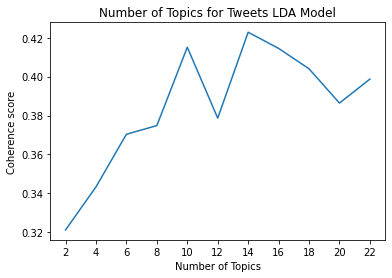

In [135]:
# Show graph
limit=24; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.xticks(x)
# plt.legend("coherence_values", loc='best')
plt.title("Number of Topics for Tweets LDA Model")
plt.show()

In [136]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3212
Num Topics = 4  has Coherence Value of 0.3433
Num Topics = 6  has Coherence Value of 0.3704
Num Topics = 8  has Coherence Value of 0.3748
Num Topics = 10  has Coherence Value of 0.4151
Num Topics = 12  has Coherence Value of 0.3787
Num Topics = 14  has Coherence Value of 0.4228
Num Topics = 16  has Coherence Value of 0.4145
Num Topics = 18  has Coherence Value of 0.404
Num Topics = 20  has Coherence Value of 0.3864
Num Topics = 22  has Coherence Value of 0.3987


In [137]:
# Select the model and print the topics
# Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’
optimal_model = model_list[4]

model_topics = optimal_model.show_topics(num_topics=10, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.084*"vaccin" + 0.074*"covid" + 0.028*"death" + 0.024*"mask" + 0.017*"die" '
  '+ 0.016*"report" + 0.016*"case" + 0.013*"protect" + 0.012*"stop" + '
  '0.012*"mandat"'),
 (1,
  '0.029*"open" + 0.028*"offic" + 0.027*"hous" + 0.027*"break" + 0.020*"start" '
  '+ 0.017*"ufs" + 0.017*"menu" + 0.017*"congress" + 0.015*"attack" + '
  '0.015*"write"'),
 (2,
  '0.049*"time" + 0.023*"elon" + 0.022*"musk" + 0.021*"free" + 0.018*"lie" + '
  '0.017*"speech" + 0.016*"thing" + 0.015*"ban" + 0.015*"elonmusk" + '
  '0.013*"account"'),
 (3,
  '0.088*"biden" + 0.082*"trump" + 0.054*"presid" + 0.017*"america" + '
  '0.015*"ukrain" + 0.014*"donald" + 0.013*"break" + 0.013*"offici" + '
  '0.013*"russia" + 0.013*"countri"'),
 (4,
  '0.027*"school" + 0.025*"support" + 0.023*"children" + 0.023*"abort" + '
  '0.018*"give" + 0.017*"good" + 0.017*"kid" + 0.016*"public" + 0.013*"texa" + '
  '0.013*"life"'),
 (5,
  '0.027*"earthquak" + 0.023*"world" + 0.022*"warn" + 0.021*"today" + '
  '0.018*"hour" + 0.0

In [138]:
def format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=processed_tweets):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bow_corpus, texts=processed_tweets)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1145,"open, offic, hous, break, start, ufs, menu, co...","[father, wear, wire, direct, catch, crimin, pl..."
1,1,1.0,0.1337,"open, offic, hous, break, start, ufs, menu, co...","[choos, communic, thing, instead, say, attract]"
2,2,5.0,0.1726,"earthquak, world, warn, today, hour, risk, maj...","[teslaownerssv, buyer, compet, electr, car, re..."
3,3,0.0,0.1000,"vaccin, covid, death, mask, die, report, case,...","[shaneyyricch, elijahschaff, iadxgyb]"
4,4,9.0,0.1611,"vote, republican, elect, democrat, state, flor...","[januari, committe, polit, sideshow, rapid, lo..."
5,5,8.0,0.1699,"leav, year, women, govern, happen, nation, cou...","[republican, parti, mouthpiec, regular, spread..."
6,6,8.0,0.1494,"leav, year, women, govern, happen, nation, cou...","[imagin, throw, away, work, richest, person, w..."
7,7,5.0,0.1846,"earthquak, world, warn, today, hour, risk, maj...","[nasa, majest, rocket, artemi, soar, space, ti..."
8,8,0.0,0.1000,"vaccin, covid, death, mask, die, report, case,...",[]
9,9,1.0,0.1228,"open, offic, hous, break, start, ufs, menu, co...","[time, magazin, cover, huge, threat, nation, s..."


In [139]:
df_dominant_topic['Topic_Perc_Contrib'].max()

0.4512

In [140]:
# Find the most representative document for each topic

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
# sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
47615,0.0,0.3272,"vaccin, covid, death, mask, die, report, case,...","[vaccin, go, right, heart, heart, express, spi..."
15529,1.0,0.3088,"open, offic, hous, break, start, ufs, menu, co...","[maskless, marjori, taylor, green, staff, bera..."
9014,2.0,0.3269,"time, elon, musk, free, lie, speech, thing, ba...","[word, groomer, categor, anti, lgbtq, hate, wo..."
40355,3.0,0.4000,"biden, trump, presid, america, ukrain, donald,...","[trump, trump, trump, trump, trump, trump, tru..."
8991,4.0,0.4512,"school, support, children, abort, give, good, ...","[chemic, abort, pill, unsaf, chemic, abort, pi..."


In [141]:
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
47615,0.0,0.3272,"vaccin, covid, death, mask, die, report, case,...","[vaccin, go, right, heart, heart, express, spi..."
15529,1.0,0.3088,"open, offic, hous, break, start, ufs, menu, co...","[maskless, marjori, taylor, green, staff, bera..."
9014,2.0,0.3269,"time, elon, musk, free, lie, speech, thing, ba...","[word, groomer, categor, anti, lgbtq, hate, wo..."
40355,3.0,0.4000,"biden, trump, presid, america, ukrain, donald,...","[trump, trump, trump, trump, trump, trump, tru..."
8991,4.0,0.4512,"school, support, children, abort, give, good, ...","[chemic, abort, pill, unsaf, chemic, abort, pi..."
28681,5.0,0.3366,"earthquak, world, warn, today, hour, risk, maj...","[swarm, earthquak, southern, california, warn,..."
37468,6.0,0.4145,"kill, white, shoot, polic, murder, black, tri,...","[black, matter, black, matter, black, matter, ..."
21662,7.0,0.3164,"american, work, year, famili, price, plan, wee...","[presid, biden, build, agenda, cost, plan, ens..."
45711,8.0,0.3333,"leav, year, women, govern, happen, nation, cou...","[critic, race, theori, teach, children, critic..."
37738,9.0,0.3365,"vote, republican, elect, democrat, state, flor...","[republican, sit, stacey, abram, chair, sign, ..."


In [142]:
tweet_vals = []

for index in sent_topics_sorteddf_mallet.index:
    tweet_vals.append(df['tweet_text'][index])

In [143]:
sent_topics_sorteddf_mallet['tweet_text'] = tweet_vals

In [144]:
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,tweet_text
47615,0.0,0.3272,"vaccin, covid, death, mask, die, report, case,...","[vaccin, go, right, heart, heart, express, spi...","""The (vaccine) goes right into the heart, hear..."
15529,1.0,0.3088,"open, offic, hous, break, start, ufs, menu, co...","[maskless, marjori, taylor, green, staff, bera...",A maskless Marjorie Taylor Greene &amp; her st...
9014,2.0,0.3269,"time, elon, musk, free, lie, speech, thing, ba...","[word, groomer, categor, anti, lgbtq, hate, wo...",The word “groomer” is categorically an anti-LG...
40355,3.0,0.4000,"biden, trump, presid, america, ukrain, donald,...","[trump, trump, trump, trump, trump, trump, tru...",Trump Won. Trump Won. Trump Won. Trump Won. Tr...
8991,4.0,0.4512,"school, support, children, abort, give, good, ...","[chemic, abort, pill, unsaf, chemic, abort, pi...",Chemical abortion pills are unsafe\nChemical a...
28681,5.0,0.3366,"earthquak, world, warn, today, hour, risk, maj...","[swarm, earthquak, southern, california, warn,...",Swarm of earthquakes hit Southern California -...
37468,6.0,0.4145,"kill, white, shoot, polic, murder, black, tri,...","[black, matter, black, matter, black, matter, ...",BLACK LIVES MATTER \nBLACK LIVES MATTER \nBLAC...
21662,7.0,0.3164,"american, work, year, famili, price, plan, wee...","[presid, biden, build, agenda, cost, plan, ens...",President Biden's Build Back Better Agenda cos...
45711,8.0,0.3333,"leav, year, women, govern, happen, nation, cou...","[critic, race, theori, teach, children, critic...",CRITICAL RACE THEORY IS NOT TAUGHT TO CHILDREN...
37738,9.0,0.3365,"vote, republican, elect, democrat, state, flor...","[republican, sit, stacey, abram, chair, sign, ...",The Republican who is sitting in Stacey Abrams...


In [184]:
sample = sent_topics_sorteddf_mallet['tweet_text'][47615]

In [185]:
def clean_up_text(text):
    url_pattern = re.compile(r'https?://\S+')

    # Remove URLs from the text
    text_without_urls = url_pattern.sub('', text)
    text = text_without_urls.replace('&quot;', '"')
    text = text.replace('&amp;', '&')

    # Print the updated text
    print(text)

In [186]:
clean_up_text(sample)

"The (vaccine) goes right into the heart, heart expresses spike protein, the body attacks the heart, there are DRAMATIC EKG changes, troponin (test for heart injury) is 10-100x higher in vax-induced myocarditis than w/natural infection." - Dr. Peter McCullough, cardiologist 


## Graphs

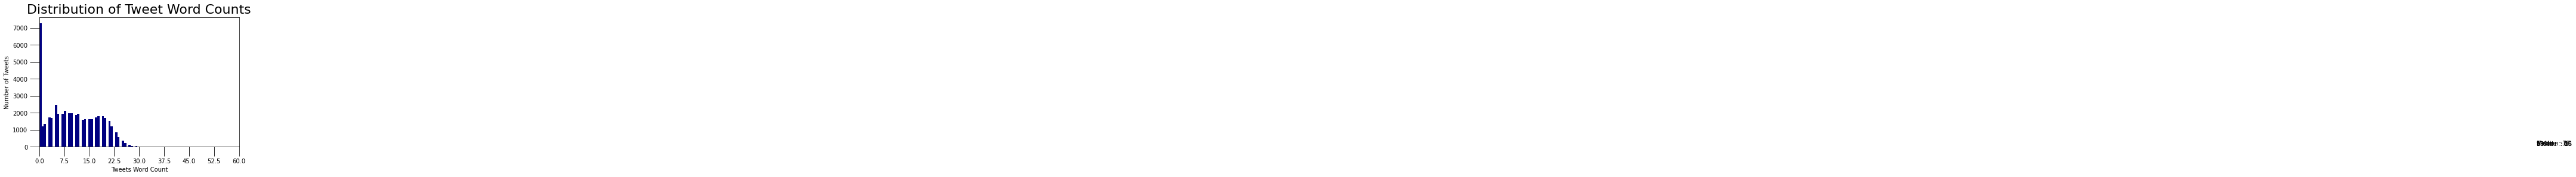

In [145]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 60), ylabel='Number of Tweets', xlabel='Tweets Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,60,9))
plt.title('Distribution of Tweet Word Counts', fontdict=dict(size=22))
plt.show()

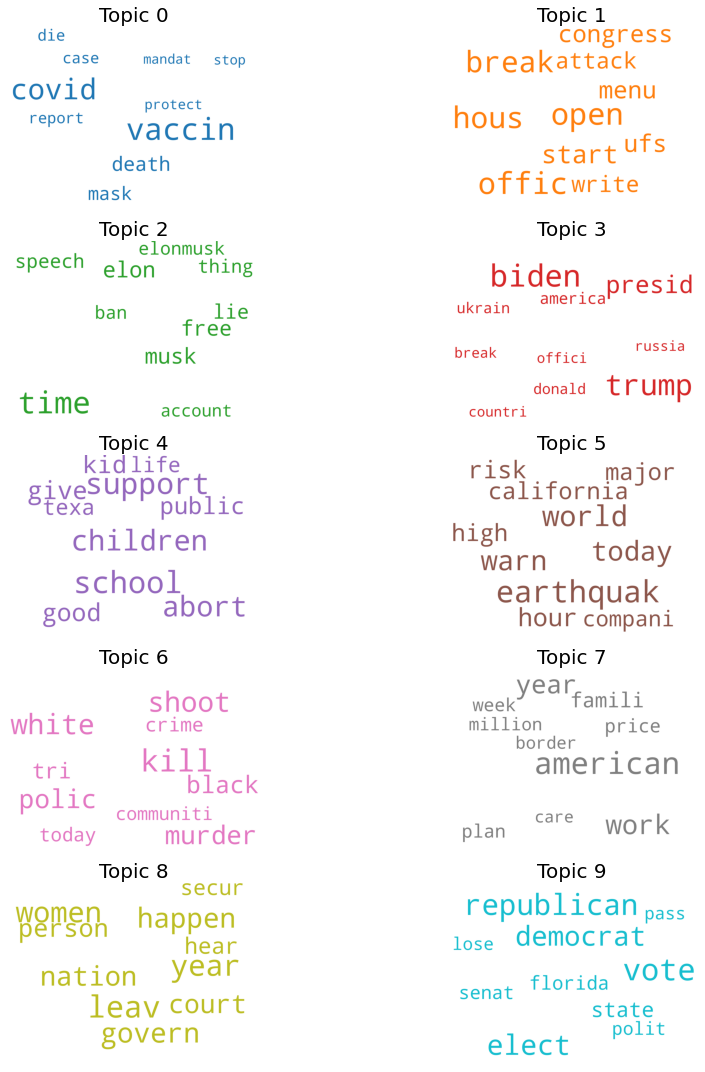

In [147]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(5, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(model_topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=20))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [148]:
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in model_topics 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]


In [149]:
# create a dictionary with topic number as key and corresponding words as value
topic_dict = {}
for topic_num, word in topic_top3words:
    if topic_num not in topic_dict:
        topic_dict[topic_num] = []
    if len(topic_dict[topic_num]) < 3:
        topic_dict[topic_num].append(word)

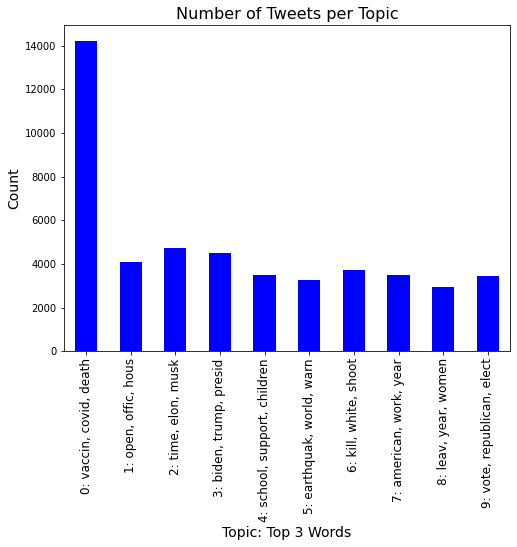

In [150]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of occurrences of each unique value in the 'topic' column
counts = df_dominant_topic['Dominant_Topic'].value_counts().sort_index()

# Create a bar plot of the counts
ax = counts.plot(kind='bar', figsize=(8, 6), color='blue')
# create list of x-axis labels

x_labels = [str(i) + ": " + ', '.join(topic_dict[i]) for i in range(len(topic_dict))]

# Set the axis labels and title
plt.xticks(range(len(topic_dict)), x_labels, rotation=90, fontsize=12)
ax.set_ylabel('Count',fontsize=14)
ax.set_xlabel('Topic: Top 3 Words',fontsize=14)
ax.set_title('Number of Tweets per Topic', fontsize=16)


# Show the plot
plt.show()


## USING Other fields

In [188]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1145,"open, offic, hous, break, start, ufs, menu, co...","[father, wear, wire, direct, catch, crimin, pl..."
1,1,1.0,0.1337,"open, offic, hous, break, start, ufs, menu, co...","[choos, communic, thing, instead, say, attract]"
2,2,5.0,0.1726,"earthquak, world, warn, today, hour, risk, maj...","[teslaownerssv, buyer, compet, electr, car, re..."
3,3,0.0,0.1000,"vaccin, covid, death, mask, die, report, case,...","[shaneyyricch, elijahschaff, iadxgyb]"
4,4,9.0,0.1611,"vote, republican, elect, democrat, state, flor...","[januari, committe, polit, sideshow, rapid, lo..."
...,...,...,...,...,...
47916,47916,3.0,0.2017,"biden, trump, presid, america, ukrain, donald,...","[elonmusk, similar, hunter, biden, laptop, mor..."
47917,47917,2.0,0.2093,"time, elon, musk, free, lie, speech, thing, ba...","[florida, teacher, tell, remov, book, classroo..."
47918,47918,3.0,0.1090,"biden, trump, presid, america, ukrain, donald,...","[america, life]"
47919,47919,4.0,0.2337,"school, support, children, abort, give, good, ...","[year, white, virginia, pack, mother, taurus, ..."


In [189]:
tweet_vals = []
classification = []
harmful = []
believable = []

for index in df_dominant_topic.index:
    tweet_vals.append(df['tweet_text'][index])
    classification.append(df['cn_classification'][index])
    harmful.append(df['cn_harmful'][index])
    believable.append(df['cn_believable'][index])

In [190]:
df_dominant_topic['tweet_text'] = tweet_vals
df_dominant_topic['misleading'] = classification
df_dominant_topic['harmful'] = harmful
df_dominant_topic['believable'] = believable

In [199]:
grouped_df = df_dominant_topic.groupby(['Dominant_Topic', 'harmful'])['tweet_text'].count().reset_index()

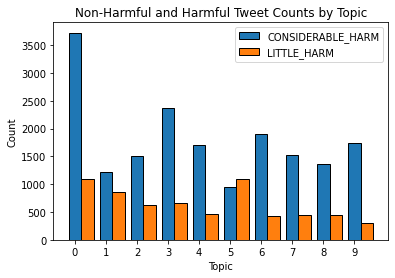

In [222]:
df_harmful = grouped_df[grouped_df['harmful'] == "CONSIDERABLE_HARM"]
df_non_harmful = grouped_df[grouped_df['harmful'] == "LITTLE_HARM"]

width = 0.4

plt.bar(df_harmful['Dominant_Topic'], df_harmful['tweet_text'], width = width, edgecolor = 'black', label='CONSIDERABLE HARM')
plt.bar(df_non_harmful['Dominant_Topic'] + width, df_non_harmful['tweet_text'], width = width, edgecolor = 'black', label='LITTLE HARM')

plt.title('Non-Harmful and Harmful Tweet Counts by Topic')

X_axis = np.arange(10)
plt.xticks(X_axis)
plt.xlabel('Topic')
plt.ylabel('Count')

plt.legend()
  
plt.show()

In [221]:
misleading_df = df_dominant_topic.groupby(['Dominant_Topic', 'classification'])['tweet_text'].count().reset_index()
misleading_df.head(5)

,Dominant_Topic,classification,tweet_text
0,0.0,MISINFORMED_OR_POTENTIALLY_MISLEADING,6090
1,0.0,NOT_MISLEADING,1015
2,1.0,MISINFORMED_OR_POTENTIALLY_MISLEADING,2920
3,1.0,NOT_MISLEADING,1187
4,2.0,MISINFORMED_OR_POTENTIALLY_MISLEADING,3764


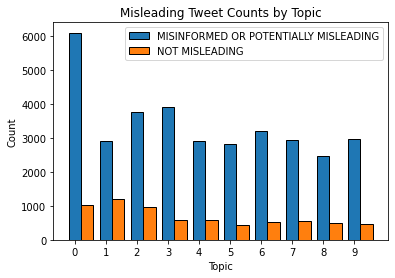

In [227]:
df_misleading = misleading_df[misleading_df['classification'] == "MISINFORMED_OR_POTENTIALLY_MISLEADING"]
df_not_misleading = misleading_df[misleading_df['classification'] == "NOT_MISLEADING"]

width = 0.4

plt.bar(df_misleading['Dominant_Topic'], df_misleading['tweet_text'], width = width, edgecolor = 'black', label='MISINFORMED OR POTENTIALLY MISLEADING')
plt.bar(df_not_misleading['Dominant_Topic'] + width, df_not_misleading['tweet_text'], width = width, edgecolor = 'black', label='NOT MISLEADING')

plt.title('Misleading Tweet Counts by Topic')

X_axis = np.arange(10)
plt.xticks(X_axis)
plt.xlabel('Topic')
plt.ylabel('Count')

plt.legend()
  
plt.show()

In [233]:
grouped_df = df_dominant_topic.groupby(['Dominant_Topic', 'harmful', 'classification'])['tweet_text'].count().reset_index()

In [234]:
grouped_df

,Dominant_Topic,harmful,classification,tweet_text
0,0.0,CONSIDERABLE_HARM,MISINFORMED_OR_POTENTIALLY_MISLEADING,3723
1,0.0,LITTLE_HARM,MISINFORMED_OR_POTENTIALLY_MISLEADING,1095
2,1.0,CONSIDERABLE_HARM,MISINFORMED_OR_POTENTIALLY_MISLEADING,1211
3,1.0,LITTLE_HARM,MISINFORMED_OR_POTENTIALLY_MISLEADING,859
4,2.0,CONSIDERABLE_HARM,MISINFORMED_OR_POTENTIALLY_MISLEADING,1506
5,2.0,LITTLE_HARM,MISINFORMED_OR_POTENTIALLY_MISLEADING,617
6,3.0,CONSIDERABLE_HARM,MISINFORMED_OR_POTENTIALLY_MISLEADING,2361
7,3.0,LITTLE_HARM,MISINFORMED_OR_POTENTIALLY_MISLEADING,659
8,4.0,CONSIDERABLE_HARM,MISINFORMED_OR_POTENTIALLY_MISLEADING,1697
9,4.0,LITTLE_HARM,MISINFORMED_OR_POTENTIALLY_MISLEADING,470


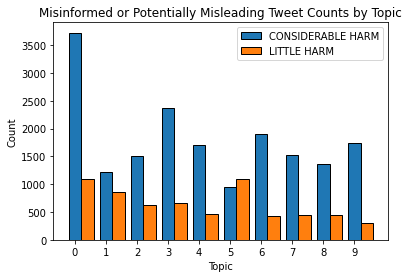

In [236]:
df_harmful = grouped_df[grouped_df['harmful'] == "CONSIDERABLE_HARM"]
df_non_harmful = grouped_df[grouped_df['harmful'] == "LITTLE_HARM"]

width = 0.4

plt.bar(df_harmful['Dominant_Topic'], df_harmful['tweet_text'], width = width, edgecolor = 'black', label='CONSIDERABLE HARM')
plt.bar(df_non_harmful['Dominant_Topic'] + width, df_non_harmful['tweet_text'], width = width, edgecolor = 'black', label='LITTLE HARM')

plt.title('Misinformed or Potentially Misleading Tweet Counts by Topic')

X_axis = np.arange(10)
plt.xticks(X_axis)
plt.xlabel('Topic')
plt.ylabel('Count')

plt.legend()
  
plt.show()

In [239]:
df_dominant_topic.to_csv("tweet_topics.csv", index=False)

In [ ]:
## topics that are misleading and not misleading
## dates of tweets
# add sentence to end of methods